In [3]:
from functools import partial

import jax
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy.special import sph_harm
from scipy.sparse.linalg import LinearOperator, lsmr
from tqdm import tqdm

(28872,) 32451 2324.4214117484066 1505.0


/var/folders/w1/lh3h4s7d5g10rdlfj4h0mshw0000gn/T/ipykernel_25573/4044505290.py:16: RuntimeWarning: divide by zero encountered in log10
  np.log10(pix_map),


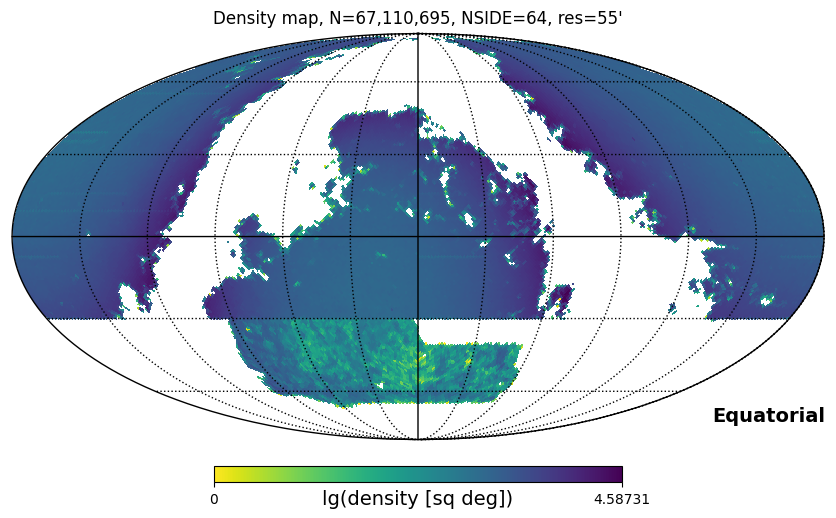

In [2]:
nside = 64
resolution_arcmin = hp.nside2resol(nside, arcmin=True)
area_sqdeg = hp.nside2pixarea(nside, degrees=True)

df = pd.read_parquet('data/stars.parquet', columns=['ps1_ra', 'ps1_dec', 'des_ra', 'des_dec'])
ra = np.where(df['ps1_ra'].isnull(), df['des_ra'], df['ps1_ra'])
dec = np.where(df['ps1_dec'].isnull(), df['des_dec'], df['ps1_dec'])
healpix = hp.ang2pix(nside, ra, dec, lonlat=True)
del df, ra, dec
pix, counts = np.unique(healpix, return_counts=True)
pix_map = np.zeros(hp.nside2npix(nside), dtype=int)
pix_map[pix] = counts / area_sqdeg
print(pix.shape, counts.max(), counts.mean(), np.median(counts))

hp.mollview(
    np.log10(pix_map),
    title=f"Density map, N={healpix.size:,d}, NSIDE={nside}, res={resolution_arcmin:.0f}'",
    cmap='viridis_r',
    bgcolor='white',
    unit='lg(density [sq deg])',
    coord='C',
    flip='astro',
)
hp.graticule()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type  | Params
--------------------------------
0 | model | Model | 10.9 K
--------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)
/Users/hombit/.virtualenvs/calibration/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/hombit/.virtualenvs/calibration/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader,

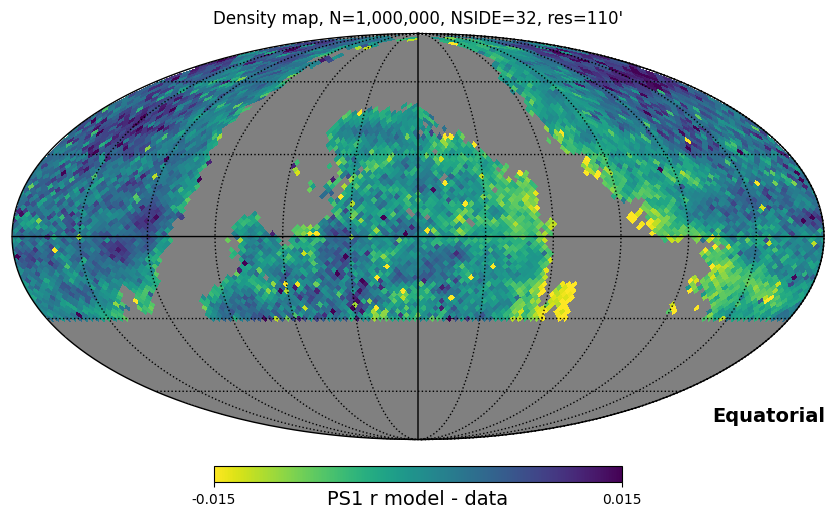

<Figure size 640x480 with 0 Axes>

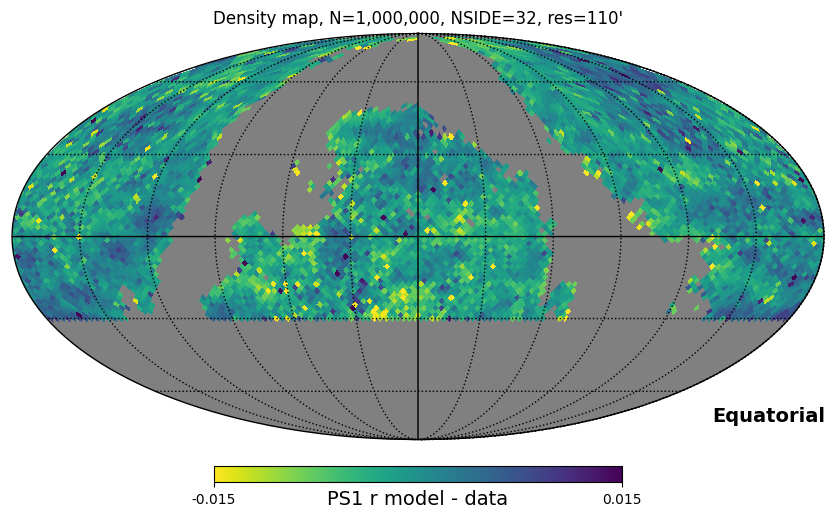

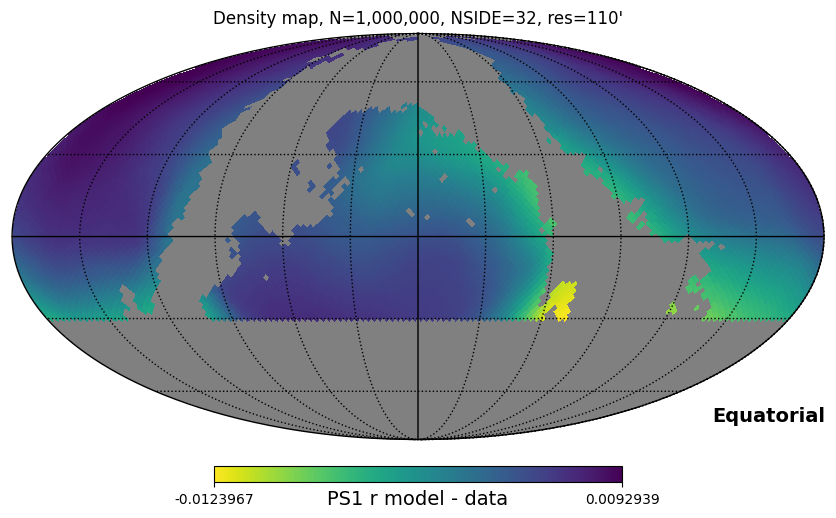

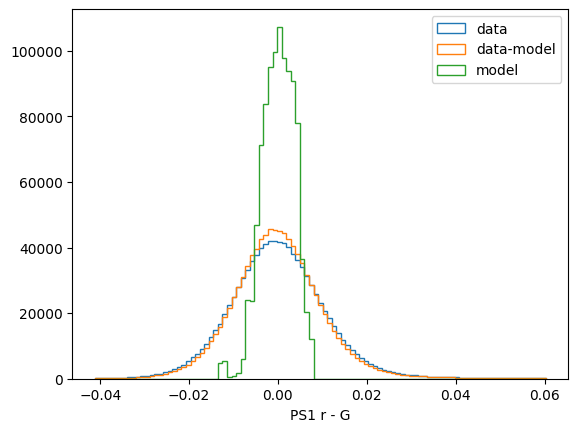

In [4]:
nside = 32
resolution_arcmin = hp.nside2resol(nside, arcmin=True)
area_sqdeg = hp.nside2pixarea(nside, degrees=True)

df = pd.read_parquet(
    'data/ps1_gaia.parquet',
    # '/Users/hombit/Documents/globus/ps1_gaia.parquet',
    columns=['ps1_ra', 'ps1_dec', 'gaia_ra', 'gaia_dec',
             'ps1_mag_g', 'ps1_magerr_g', 'ps1_mag_r', 'ps1_magerr_r',
             'gaia_mag_G', 'gaia_magerr_G',
             'gaia_mag_BP', 'gaia_mag_RP'],
)
target_band = 'r'
transformed = pd.read_parquet(f'data/ps1_gaia--PS1_{target_band}.parquet', columns=[f'ps1_mag_{target_band}'])[f'ps1_mag_{target_band}']

bp_rp_median = -0.5
n_objects = 1_000_000
bp_rp = df['gaia_mag_BP'] - df['gaia_mag_RP']
idx_sort_gp_rp = np.argsort(bp_rp)
bp_rp_median_idx = idx_sort_gp_rp[np.searchsorted(bp_rp.iloc[idx_sort_gp_rp], bp_rp_median)]
bp_rp_idx = idx_sort_gp_rp[bp_rp_median_idx - n_objects // 2:bp_rp_median_idx + n_objects // 2]

df = df.iloc[bp_rp_idx]
transformed = transformed.iloc[bp_rp_idx]
assert df.shape[0] == n_objects

ra, dec = df[f'ps1_ra'].to_numpy(), df[f'ps1_dec'].to_numpy()
theta, phi = np.deg2rad(ra), np.deg2rad(90 - dec)
healpix = hp.ang2pix(nside, ra, dec, lonlat=True)
pix = np.unique(healpix)

def plot_skymap(offsets, **kwargs):
    weighted_offsets = offsets / (df[f'ps1_magerr_{target_band}'] ** 2 + df['gaia_magerr_G'] ** 2)
    weighted_sums = ndimage.sum_labels(
        weighted_offsets,
        labels=healpix,
        index=pix,
    )
    weights = ndimage.sum_labels(
        1.0 / (df[f'ps1_magerr_{target_band}'] ** 2 + df['gaia_magerr_G'] ** 2),
        labels=healpix,
        index=pix,
    )
    pix_map = np.full(hp.nside2npix(nside), np.nan)
    pix_map[pix] = weighted_sums / weights

    hp.mollview(
        pix_map,
        title=f"Density map, N={healpix.size:,d}, NSIDE={nside}, res={resolution_arcmin:.0f}'",
        cmap='viridis_r',
        bgcolor='white',
        unit=f'PS1 {target_band} model - data',
        coord='C',
        flip='astro',
        **kwargs,
    )
    hp.graticule()

# offset = np.array(df[f'ps1_mag_{target_band}'] - df['gaia_mag_G'])
offset = np.array(transformed - df[f'ps1_mag_{target_band}'])

plot_skymap(offset - offset.mean(), min=-0.015, max=0.015)


def sph_pol_indeces(order):
    indeces = []
    for l in range(order+1):
        for m in range(-l, l+1):
            indeces.append((m, l))
    m, l = zip(*indeces)
    return np.array(m), np.array(l)


def sph_pol(coeffs):
    coeffs = np.array(coeffs)
    assert coeffs.size > 0
    assert (np.sqrt(coeffs.shape[0]) - 1) % 1 == 0, str(coeffs.size)
    order = int(np.sqrt(coeffs.shape[0]) - 1)

    def f(ra, dec):
        theta = np.deg2rad(90 - dec)
        phi = np.deg2rad(ra)
        result = 0.0
        for i, (m, l) in enumerate(zip(*sph_pol_indeces(order))):
            result += coeffs[i] * sph_harm(m, l, phi, theta)
        return result.real

    return f


def make_linear_operator(theta, phi, order: int, *, batch_size: int = 100_000_000):
    assert theta.size == theta.shape[0] == phi.size == phi.shape[0]
    n_lines = theta.size
    n_rows = (order + 1) ** 2
    lines_per_batch = 1 << int(np.log2(batch_size / n_rows))

    def matvec(v):
        assert v.shape == (n_rows,)
        result = np.zeros(n_lines)
        for i_batch in range(0, n_lines, lines_per_batch):
            result[i_batch:i_batch + lines_per_batch] = sph_harm(
                *sph_pol_indeces(order),
                theta[i_batch:i_batch + lines_per_batch, None],
                phi[i_batch:i_batch + lines_per_batch, None],
            ).real @ v
        return result

    def rmatvec(v):
        result = np.zeros(n_rows)
        for i_batch in range(0, n_lines, lines_per_batch):
            result += sph_harm(
                *sph_pol_indeces(order),
                theta[i_batch:i_batch + lines_per_batch, None],
                phi[i_batch:i_batch + lines_per_batch, None],
            ).real.T @ v[i_batch:i_batch + lines_per_batch]
        return result

    return LinearOperator(shape=(n_lines, n_rows), matvec=matvec, rmatvec=rmatvec)


def fit_sph_harm(ra, dec, values, order):
    Y = sph_pol(np.eye((order + 1)**2)[..., None])
    A = Y(ra, dec).T
    print(A.shape)
    coeffs, res, rank, s = np.linalg.lstsq(A, values, rcond=None)
    return sph_pol(coeffs)
# def fit_sph_harm(theta, phi, values, *, order):
#     A = make_linear_operator(theta, phi, order)
#     assert A.shape[0] == values.size
#     coeffs, istop, itn, normr, normar, norma, conda, normx = lsmr(A, values, maxiter=A.shape[1] * 2, show=True)
#     return sph_pol(coeffs)


plt.figure()
idx = (offset < np.quantile(offset, 0.999)) & (offset > np.quantile(offset, 0.001))

# f = fit_sph_harm(ra[idx][::100], dec[idx][::100], offset[idx][::100], order=30)
# f= fit_sph_harm(ra[::100], dec[::100], offset[idx][::100], order=20)
# f = fit_sph_harm(theta[idx], phi[idx], offset[idx], order=20)

from calibration.position_correlation.train import train
f = train(ra[idx][::300], dec[idx][::300], offset[idx][::300], variance_deg=1.0, n_epoch=10_000)

plot_skymap(offset - f(ra, dec), min=-0.015, max=0.015)

plot_skymap(f(ra, dec))

plt.figure()
plt.hist(offset-offset.mean(), bins=np.linspace(*np.quantile(offset, [0.001, 0.999]), 100), label='data', histtype='step')
plt.hist(offset-f(ra, dec), bins=np.linspace(*np.quantile(offset, [0.001, 0.999]), 100), label='data-model', histtype='step')
plt.hist(f(ra, dec) - f(ra, dec).mean(), bins=np.linspace(*np.quantile(offset, [0.001, 0.999]), 100), label='model', histtype='step')
plt.xlabel(f'PS1 {target_band} - G')
plt.legend()

In [5]:
import re
from io import BytesIO, SEEK_END

from astropy.io import ascii
from astropy.coordinates import SkyCoord

def read_table(filename, columns):
    io = BytesIO(rf'''
        \begin{{table}}
        \begin{{tabular}}{{{'l'*len(columns)}}}
        {'&'.join(columns)}
    '''.encode())
    io.seek(0, SEEK_END)
    with open(filename, 'rb') as fh:
        content = fh.read()
        content = re.sub(br'\\phantom{[^}]*}', br'', content)
        io.write(content)
    io.write(br'''
        \end{tabular}
        \end{table}
    ''')
    io.seek(0)
    table = ascii.read(io, format='latex', converters={'*': str})
    return table

table = read_table(
    'axelrod_tables/Table1.tex',
    columns=['Star', 'Orig. name', 'RA', 'DEC', 'PM_RA', 'PM_DEC', 'G', 'Rp', 'Bp',],
)
names_coords = {name: SkyCoord(ra=ra, dec=dec, unit=['hour', 'deg'])
                for name, ra, dec in table[['Star', 'RA', 'DEC']] if name.startswith('WDFS')}
del table

ps1_table = read_table(
    'axelrod_tables/Table8.tex',
    columns=['obj', 'g', 'gSynth', 'r', 'rSynth', 'i', 'iSynth', 'z', 'zSynth']
)
for column in ps1_table.columns:
    if not column.endswith('Synth'):
        continue
    ps1_table[column] = np.asarray(ps1_table[column], dtype=float)
ps1_table.add_index('obj')

ps1_table['coord'] = [names_coords[name] for name in ps1_table['obj']]
ps1_table['rmag'] = [float(str(s).split()[0]) for s in ps1_table['r']]
ps1_table['rmagerr'] = [float(str(s).split()[1][1:-1]) * 1e-3 for s in ps1_table['r']]
ps1_table['r_synth_obs'] = ps1_table['rSynth'] - ps1_table['rmag']

In [6]:
print(np.count_nonzero([np.any((np.abs(wd_coord.ra.deg - ra) < 0.1) & (np.abs(wd_coord.dec.deg - dec) < 0.1)) for wd_coord in ps1_table["coord"]]))
print(len(ps1_table))

model_offsets = f(ps1_table['coord'].ra.deg, ps1_table['coord'].dec.deg)
model_offsets -= np.average(model_offsets,
                            weights=1.0 / ps1_table['rmagerr'] ** 2)

wd_offsets = ps1_table['r_synth_obs'] - np.average(ps1_table['r_synth_obs'], weights=1.0 / ps1_table['rmagerr'] ** 2)

wd_chi2 = np.sum(wd_offsets ** 2 / ps1_table['rmagerr'] ** 2)
model_wd_chi2 = np.sum((wd_offsets - model_offsets) ** 2 / ps1_table['rmagerr'] ** 2)

print(f'{wd_chi2=:.2f}, {model_wd_chi2=:.2f}')
print(np.vstack([wd_offsets, model_offsets]).T)

7
19
wd_chi2=127.77, model_wd_chi2=132.90
[[-2.16363689e-02 -1.57322967e-04]
 [-1.36363689e-02  7.63111282e-04]
 [ 4.23636311e-02  8.50972719e-04]
 [-3.46363689e-02  5.46264928e-05]
 [-1.56636369e-01  2.47582654e-03]
 [ 1.53636311e-02  2.61781318e-03]
 [-3.63636891e-03 -1.34695647e-03]
 [ 2.43636311e-02  5.09653520e-03]
 [-3.66363689e-02  1.05630746e-03]
 [-1.76363689e-02  4.53208294e-03]
 [ 1.36363109e-03  2.45159958e-04]
 [-5.63636891e-03 -2.69290386e-03]
 [ 8.36363109e-03 -3.40919220e-03]
 [ 1.36363109e-03  1.41125033e-03]
 [-4.66363689e-02 -7.22201495e-03]
 [-1.56363689e-02  7.13648275e-04]
 [ 3.36363109e-03 -2.99313432e-03]
 [ 2.33636311e-02  4.37682960e-04]
 [ 2.36363109e-03 -5.58437686e-03]]


In [ ]:
from pyshtools.expand import SHExpandLSQ

SHExpandLSQ(offset[idx], dec[idx], ra[idx], lmax=30, norm=4)

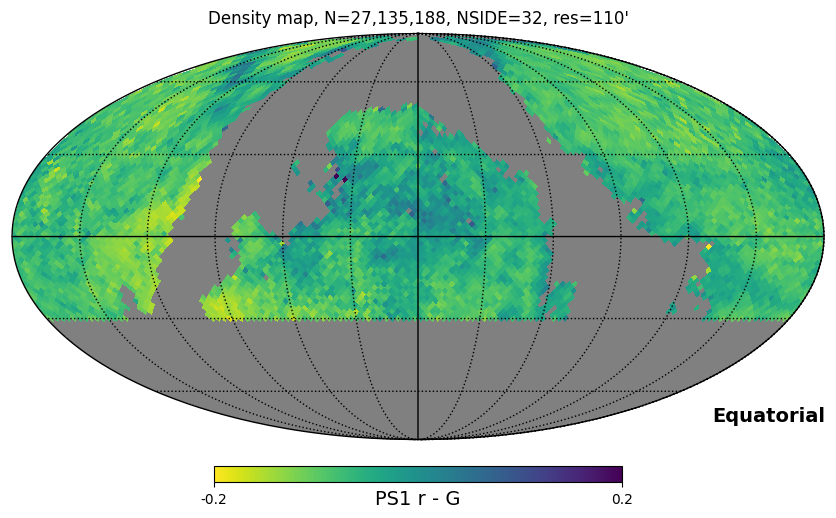

In [10]:
df_gaia = pd.read_parquet(
    'data/ps1_gaia.parquet',
    # '/Users/hombit/Documents/globus/ps1_gaia.parquet',
    columns=['gaia_mag_BP', 'gaia_mag_RP',],
)
bp_rp = df_gaia['gaia_mag_BP'] - df_gaia['gaia_mag_RP']
plot_skymap(bp_rp - bp_rp.mean(), min=-0.2, max=0.2)

(array([1.651000e+03, 1.957000e+03, 2.392000e+03, 2.760000e+03,
        3.681000e+03, 4.604000e+03, 6.011000e+03, 7.656000e+03,
        1.023400e+04, 1.365700e+04, 1.868500e+04, 2.475200e+04,
        3.252800e+04, 4.177400e+04, 5.389000e+04, 7.042000e+04,
        9.495700e+04, 1.371140e+05, 2.054210e+05, 3.238860e+05,
        5.233730e+05, 8.397380e+05, 1.302226e+06, 1.902054e+06,
        2.552080e+06, 3.087482e+06, 3.328540e+06, 3.188823e+06,
        2.731531e+06, 2.120257e+06, 1.517788e+06, 1.026674e+06,
        6.724880e+05, 4.300020e+05, 2.733240e+05, 1.747190e+05,
        1.129880e+05, 7.488600e+04, 5.151200e+04, 3.603000e+04,
        2.653000e+04, 1.945900e+04, 1.481600e+04, 1.164600e+04,
        9.124000e+03, 7.167000e+03, 5.695000e+03, 4.481000e+03,
        3.655000e+03, 3.044000e+03, 2.395000e+03, 1.980000e+03,
        1.647000e+03, 1.400000e+03, 1.167000e+03, 9.670000e+02,
        7.680000e+02, 6.370000e+02, 5.410000e+02, 4.660000e+02,
        4.280000e+02, 3.460000e+02, 3.21

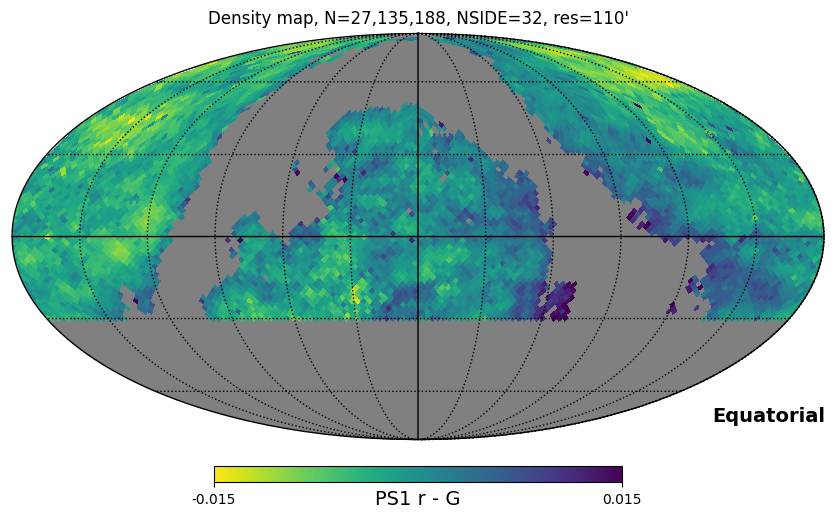

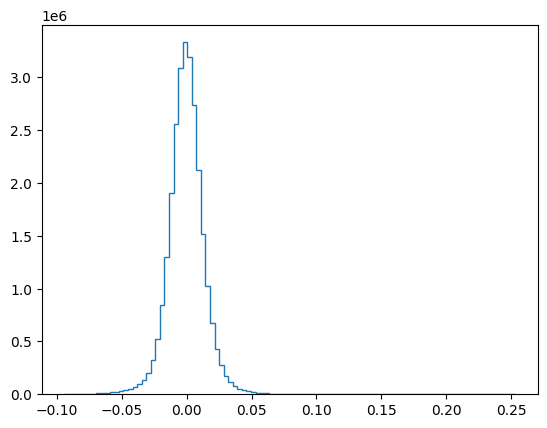

In [13]:
r_origin = pd.read_parquet('data/ps1_gaia.parquet', columns=['ps1_mag_r'])['ps1_mag_r']
r_transformed = pd.read_parquet('data/ps1_gaia--PS1_r.parquet', columns=['ps1_mag_r'])['ps1_mag_r']
r_offset = r_origin - r_transformed
plot_skymap(r_offset - r_offset.mean(), min=-0.015, max=0.015)
plt.figure()
plt.hist(r_offset, bins=np.linspace(*np.quantile(offset, [0.001, 0.999]), 100), label='data', histtype='step')